In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from enum import Enum
from typing import Any, List
import matplotlib.pyplot as plt

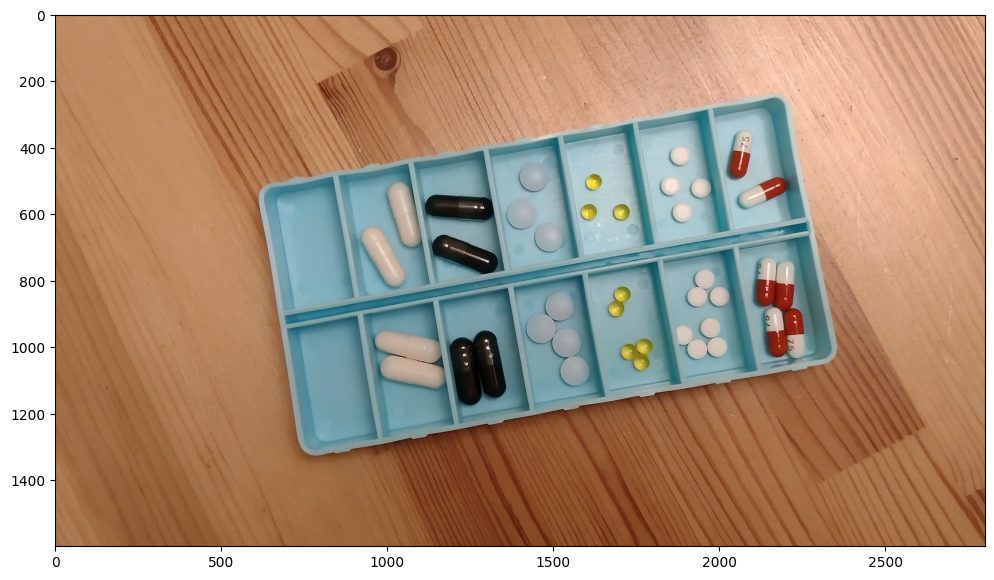

In [8]:
calib = cv2.imread('calib.png')
plt.subplots(1, 1, figsize=(12,8))[1].imshow(calib[..., ::-1]);

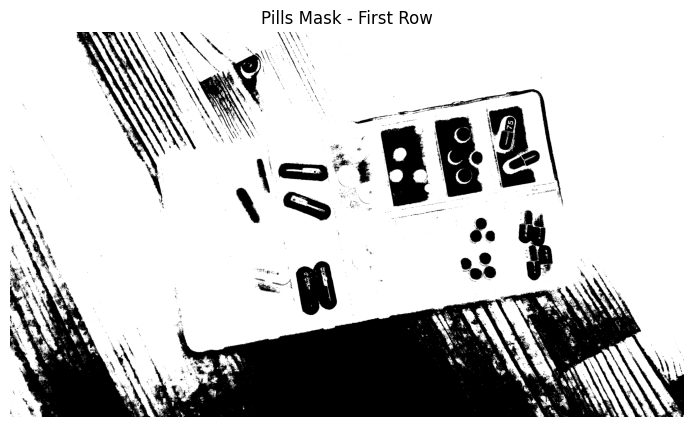

In [3]:
  # Update this based on the actual image

# Now, let's try to make the pills white and the background black.
# We will use color thresholds in the HSV color space to isolate the pills.

# Convert the ROI to HSV color space
# roi_hsv = cv2.cvtColor(calib, cv2.COLOR_RGB2HSV)

# # Initialize an empty mask for the pills
# pills_mask = np.zeros_like(roi_hsv[:, :, 0])

# # Define color thresholds for different pill types in the HSV color space
# # The values would need to be determined experimentally
# # Here, we're setting some example ranges for each pill type
# # These ranges would need to be fine-tuned for accurate segmentation
# color_thresholds = {
#     'white_pills': ((0, 0, 200), (180, 60, 255)),   # Example range for white
#     'black_pills': ((0, 0, 0), (180, 255, 50)),     # Example range for black
#     'blue_pills': ((100, 150, 0), (140, 255, 255)), # Example range for blue
#     'yellow_pills': ((25, 150, 150), (35, 255, 255)), # Example range for yellow
#     # Add more thresholds for other pill types if necessary
# }

# # Create a mask for each pill type based on the thresholds and combine them
# for color_range in color_thresholds.values():
#     lower_bound, upper_bound = color_range
#     mask = cv2.inRange(roi_hsv, lower_bound, upper_bound)
#     pills_mask = cv2.bitwise_or(pills_mask, mask)

# # Invert the mask to make pills white and background black
# pills_mask_inv = cv2.bitwise_not(pills_mask)

# # Visualize the result
# plt.figure(figsize=(10, 5))
# plt.imshow(pills_mask_inv, cmap='gray')
# plt.title('Pills Mask - First Row')
# plt.axis('off')
# plt.show()

In [1]:
# import cv2
# import numpy as np
# from skimage.segmentation import slic
# from skimage.feature import local_binary_pattern
# from skimage.color import label2rgb
# from matplotlib import pyplot as plt

# # Load the superpixel output image
# superpixel_output_path = '/mnt/data/image.png'
# superpixel_image = cv2.imread(superpixel_output_path)
# superpixel_image_rgb = cv2.cvtColor(superpixel_image, cv2.COLOR_BGR2RGB)

# # Apply SLIC on the original image to get superpixels
# # The number of segments, compactness, and max iterations can be tuned
# num_segments = 100  # example value, needs to be tuned
# compactness = 10   # example value, needs to be tuned
# max_iter = 10      # example value, needs to be tuned

# # Convert to float data type and scale to [0, 1] for SLIC algorithm
# superpixel_image_norm = np.float32(superpixel_image_rgb) / 255.0
# segments_slic = slic(superpixel_image_norm, n_segments=num_segments, compactness=compactness, max_iter=max_iter)

# # Calculate the average color within each superpixel segment
# average_colors = np.zeros((segments_slic.max() + 1, 3), dtype=float)
# for segment_val in np.unique(segments_slic):
#     mask = segments_slic == segment_val
#     average_colors[segment_val, :] = superpixel_image_rgb[mask].mean(axis=0)

# # Map average color to each segment to create an average color image
# average_color_image = average_colors[segments_slic]

# # Convert average color image to grayscale
# average_color_image_gray = cv2.cvtColor(np.uint8(average_color_image), cv2.COLOR_RGB2GRAY)

# # Apply Local Binary Pattern to the grayscale average color image
# # The parameters for LBP can be tuned based on the texture of the pills
# radius = 3  # example value, needs to be tuned
# n_points = 8 * radius  # example value, needs to be tuned
# lbp_image = local_binary_pattern(average_color_image_gray, n_points, radius, method='uniform')

# # Threshold the LBP image to create a binary mask
# # We use Otsu's method to automatically determine the threshold value
# _, binary_mask = cv2.threshold(np.uint8(lbp_image), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# # Visualize the results
# plt.figure(figsize=(20, 10))

# plt.subplot(1, 3, 1)
# plt.imshow(label2rgb(segments_slic, superpixel_image_rgb, kind='avg'))
# plt.title('SLIC Superpixels')
# plt.axis('off')

# plt.subplot(1, 3, 2)
# plt.imshow(average_color_image_gray, cmap='gray')
# plt.title('Average Color Image (Grayscale)')
# plt.axis('off')

# plt.subplot(1, 3, 3)
# plt.imshow(binary_mask, cmap='gray')
# plt.title('Binary Mask from LBP')
# plt.axis('off')

# plt.show()


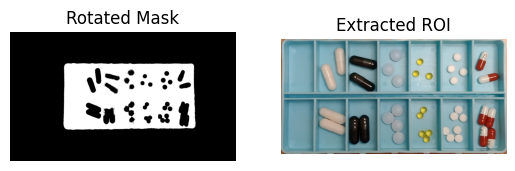

In [9]:
def convert_to_hsv(bgr_image):
    return cv2.cvtColor(bgr_image, cv2.COLOR_BGR2HSV)

# Helper function to create color mask
def create_color_mask(hsv_image, lower_bound, upper_bound):
    return cv2.inRange(hsv_image, lower_bound, upper_bound)

# Helper function to apply rotation
def apply_rotation(image, rotation_angle):
    height, width = image.shape[:2]
    rotation_center = (width // 2, height // 2)
    rotation_matrix = cv2.getRotationMatrix2D(rotation_center, rotation_angle, scale=1.0)
    return cv2.warpAffine(image, rotation_matrix, (width, height))

# Function to find the largest connected component
def find_largest_connected_component(mask):
    # Apply Canny edge detection
    edges = cv2.Canny(mask, 100, 200)

    # Use morphological closing to fill gaps in edges
    kernel = np.ones((5, 5), np.uint8)
    closed_edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

    # Find connected components
    num_labels, labels = cv2.connectedComponents(closed_edges)

    # Find the largest connected component
    max_label = 0
    max_size = 0
    for label in range(1, num_labels):
        size = np.sum(labels == label)
        if size > max_size:
            max_label = label
            max_size = size

    largest_component = np.zeros_like(mask)
    largest_component[labels == max_label] = 255

    return largest_component

# Convert source image to HSV
hsv_image = convert_to_hsv(calib)

# Define blue color range and create mask
lower_blue = np.array([70, 20, 20], np.uint8)
upper_blue = np.array([100, 255, 255], np.uint8)
mask = create_color_mask(hsv_image, lower_blue, upper_blue)

# Apply rotation if needed (example -10 degrees)
rotated_mask = apply_rotation(mask, -10)
rotated_image = apply_rotation(calib, -10)

# Find the largest connected component
largest_component = find_largest_connected_component(rotated_mask)

# Crop the region of interest from the rotated image
x, y, w, h = cv2.boundingRect(largest_component)
roi_from_image = rotated_image[y:y+h, x:x+w]
roi_mask = rotated_mask[y:y+h, x:x+w]

# Displaying results
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(rotated_mask, cv2.COLOR_BGR2RGB))
plt.title("Rotated Mask")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(roi_from_image, cv2.COLOR_BGR2RGB))
plt.title("Extracted ROI")
plt.axis('off')

plt.show()

Dany jest obraz wzorcowy `calib` przedstawiający leki w organizerze.
Twoim zadaniem będzie zaproponowanie algorytmu detekcji, który przyjmie obraz wejściowy i wykryje na nim obiekty - poszczególne tabletki, zwracając informację o ich położeniach i gatunkach.
Reprezentacja tej informacji jest dowolna: pary koordynat (X,Y) środka obiektu, bounding boksy (XYHW), czy kontury - istotne jest jedynie, by liczba detekcji możliwie dobrze zgadzała się ze stanem faktycznym.

Zadanie ma charakter projektowy i nie jest podzielone na szczegółowo opisane podpunkty, ponieważ można do niego podejść na różne sposoby (czytaj dalej).

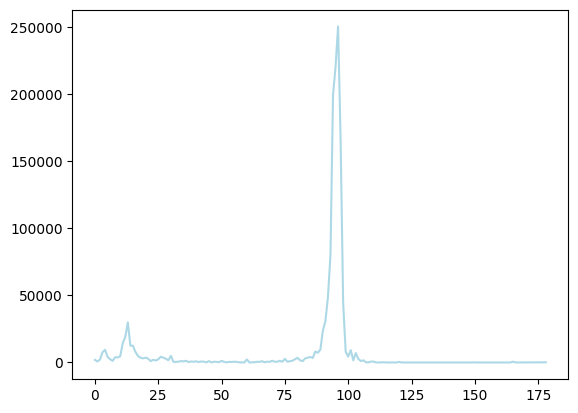

In [15]:
hsv_roi_pillbox = cv2.cvtColor(roi_from_image, cv2.COLOR_BGR2HSV)
h,s,v = cv2.split(hsv_roi_pillbox)
hist_h = cv2.calcHist([h],[0],None,[179],[0,179])
plt.plot(hist_h, color='lightblue', label="hue")

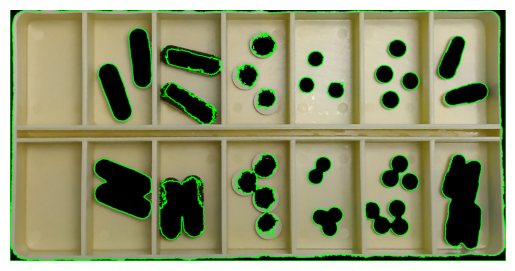

In [75]:
# import imutils

# def apply_contours_to_black_areas(image, mask):
#     # Invert the mask to focus on black areas
#     inverted_mask = cv2.bitwise_not(mask)

#     # Find contours in the inverted mask
#     contours, _ = cv2.findContours(inverted_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#     # Draw contours on the image
#     cv2.drawContours(image, contours, -1, (0, 255, 0), 2)  # Drawing in black

#     return image

# # Your existing code
# def apply_color_mask_to_roi(roi_image, lower_bound, upper_bound):
#     # Convert ROI image to HSV color space
#     hsv_roi = cv2.cvtColor(roi_image, cv2.COLOR_BGR2HSV)
#     mask = cv2.inRange(hsv_roi, lower_bound, upper_bound)
#     masked_image = cv2.bitwise_and(roi_image, roi_image, mask=mask)
#     return masked_image, mask

# custom_hue_min = np.array([70, 20, 20], np.uint8)
# custom_hue_max = np.array([100, 255, 255], np.uint8)

# masked_image, mask = apply_color_mask_to_roi(roi_from_image, custom_hue_min, custom_hue_max)

# # Apply contours to the black areas
# contoured_image = apply_contours_to_black_areas(masked_image, mask)
# plt.imshow(contoured_image)
# plt.axis('off')
# plt.show()


In [76]:
# from scipy import ndimage
# from skimage.feature import peak_local_max
# from skimage.segmentation import watershed
# import numpy as np
# import cv2

# # Assuming 'thresh' is a binary thresholded image
# # You would create 'thresh' by applying some thresholding method to your original image

# # Compute the Euclidean distance transform
# D = ndimage.distance_transform_edt(masked_image)

# # Find local maxima
# local_max_coordinates = peak_local_max(D, min_distance=1, labels=masked_image)
# # Convert local maxima coordinates to a boolean mask
# local_max_mask = np.zeros_like(D, dtype=bool)
# local_max_mask[tuple(local_max_coordinates.T)] = True

# # Perform a connected component analysis on the local peaks, using 8-connectivity
# markers, _ = ndimage.label(local_max_mask)

# # Apply the Watershed algorithm
# labels = watershed(-D, markers, mask=masked_image)

# # Output the number of unique segments found
# print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))

# plt.figure(figsize=(12, 6))

# plt.imshow(D, cmap='gray')
# plt.title('Euclidean Distance Transform')
# plt.axis('off')

# plt.show()



KeyboardInterrupt: 

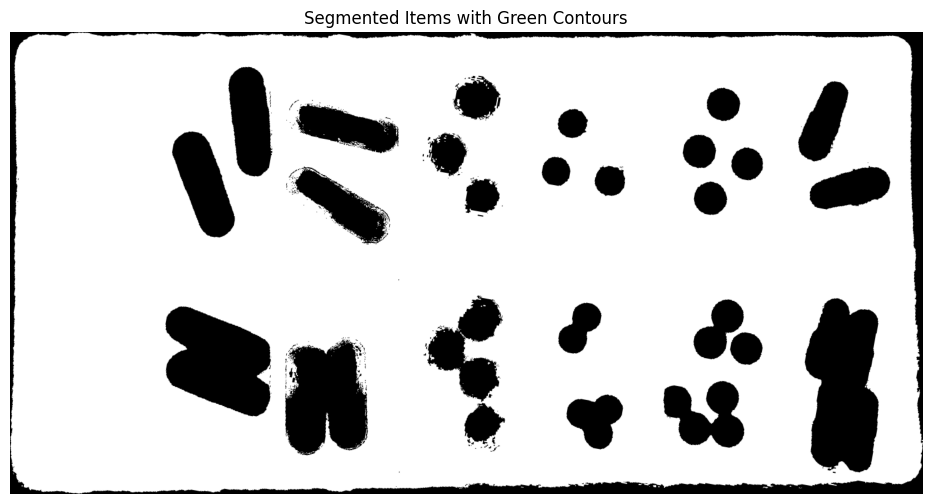

In [71]:
# for label in np.unique(labels):
#     if label == 0:  # Skip background
#         continue

#     # Create a mask for the current label
#     label_mask = np.zeros(masked_image.shape, dtype="uint8")
#     label_mask[labels == label] = 255

#     # Find contours on the mask
#     contours, _ = cv2.findContours(label_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# # Visualize the result with contours
# plt.figure(figsize=(12, 6))
# plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
# plt.title('Segmented Items with Green Contours')
# plt.axis('off')
# plt.show()

Dany jest obraz wzorcowy `calib` przedstawiający leki w organizerze.
Twoim zadaniem będzie zaproponowanie algorytmu detekcji, który przyjmie obraz wejściowy i wykryje na nim obiekty - poszczególne tabletki, zwracając informację o ich położeniach i gatunkach.
Reprezentacja tej informacji jest dowolna: pary koordynat (X,Y) środka obiektu, bounding boksy (XYHW), czy kontury - istotne jest jedynie, by liczba detekcji możliwie dobrze zgadzała się ze stanem faktycznym.

Zadanie ma charakter projektowy i nie jest podzielone na szczegółowo opisane podpunkty, ponieważ można do niego podejść na różne sposoby (czytaj dalej).

In [17]:
import cv2
import numpy as np
from enum import Enum

hsv_image = convert_to_hsv(roi_from_image)

class PillType(Enum):
    PROBIO = 1  # large white capsules
    CARBON = 2  # large black capsules
    KETO = 3    # blue pills
    ESPU = 4    # small yellow capsules
    BIOX = 5    # small white tablets
    LINE = 6    # red and white capsules

# Existing color_ranges dictionary
color_ranges = {
    PillType.PROBIO:  ([0, 0, 168], [50, 111, 255]),
    PillType.CARBON: ([0, 0, 0], [255, 100, 70]),
    PillType.KETO: ([50, 0, 168], [172, 111, 255]),
    PillType.ESPU: ([20, 80, 80], [35, 255, 255]),
    PillType.BIOX: ([0, 0, 168], [50, 111, 255]),
}

# Define the custom mask range for hues 80 to 100
custom_hue_min = np.array([70, 20, 20], np.uint8)
custom_hue_max = np.array([100, 255, 255], np.uint8)
custom_mask = cv2.inRange(hsv_image, custom_hue_min, custom_hue_max)

def create_masks(hsv_image, color_ranges, custom_mask):
    masks = {}
    for pill_type, (lower, upper) in color_ranges.items():
        lower = np.array(lower, dtype="uint8")
        upper = np.array(upper, dtype="uint8")

        # Create the mask for each pill type
        mask = cv2.inRange(hsv_image, lower, upper)

        # Combine with the custom mask to exclude the specified hue range
        mask = cv2.bitwise_and(mask, mask, mask=~custom_mask)

        if pill_type == PillType.BIOX:
            x_threshold = hsv_image.shape[1] * 0.85
            # Find connected components
            num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
            # Define thresholds
            min_component_area = 600  # Minimum area for small components; adjust as necessary
            max_component_area = 5000  # Maximum area for large components; adjust as necessary

            # Create an output mask that will only include medium-sized components
            medium_components = np.zeros_like(mask)

            # Filter out small and large components
            for i in range(1, num_labels):  # start from 1 to ignore the background
                component_area = stats[i, cv2.CC_STAT_AREA]
                if min_component_area <= component_area <= max_component_area:
                    # If component is medium-sized, include it in the output mask
                    medium_components[labels == i] = 255

            # Update the mask to be the medium components mask
            mask = medium_components

            num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)

            filtered_components = np.zeros_like(mask)

            # Filter out components based on the x_threshold
            for i in range(1, num_labels):  # start from 1 to ignore the background
                # Use the x-coordinate of the centroid or bounding box for filtering
                x_centroid = centroids[i][0]
                # You can also use the bounding box x-coordinate with 'x = stats[i, cv2.CC_STAT_LEFT]'
                
                if x_centroid < x_threshold:
                    filtered_components[labels == i] = 255

            # Update the mask to be the filtered components mask
            mask = filtered_components

        if pill_type == PillType.PROBIO:
            num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
            # Filter out small components which may be unconnected lines
            min_component_area = 5000  # This is an example value; adjust as necessary
            large_components = np.zeros_like(mask)
            for i in range(1, num_labels):  # start from 1 to ignore the background
                if stats[i, cv2.CC_STAT_AREA] >= min_component_area:
                    large_components[labels == i] = 255
            mask = large_components


        # Check if this is the CARBON pill type, which represents the large black capsules
        if pill_type == PillType.CARBON:

            kernel = np.ones((30, 30), np.uint8)

            mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
            mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        if pill_type == PillType.KETO:
            kernel_size = 5  # Example size; you might need to adjust this
            kernel = np.ones((kernel_size, kernel_size), np.uint8)
            # Apply morphological opening to the KETO mask to remove small artifacts
            mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

            kernel = np.ones((10, 10), np.uint8)

            mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
            mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

            num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
            # Filter out small components which may be unconnected lines
            min_component_area = 800  # This is an example value; adjust as necessary
            large_components = np.zeros_like(mask)
            for i in range(1, num_labels):  # start from 1 to ignore the background
                if stats[i, cv2.CC_STAT_AREA] >= min_component_area:
                    large_components[labels == i] = 255
            mask = large_components



        masks[pill_type] = mask

    return masks

# Create masks
masks = create_masks(hsv_image, color_ranges, custom_mask)

# Check if masks were created successfully
print(masks.keys(), [mask.shape for mask in masks.values()])





dict_keys([<PillType.PROBIO: 1>, <PillType.CARBON: 2>, <PillType.KETO: 3>, <PillType.ESPU: 4>, <PillType.BIOX: 5>]) [(830, 1639), (830, 1639), (830, 1639), (830, 1639), (830, 1639)]


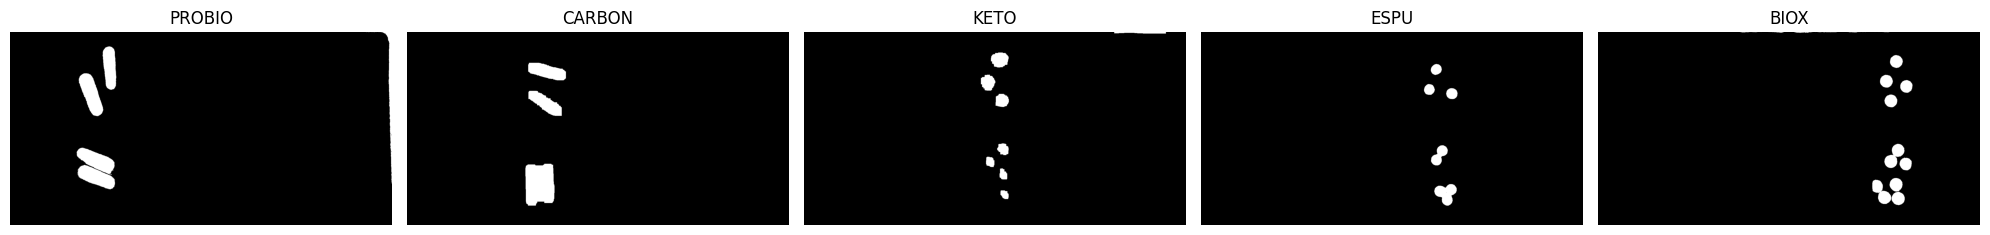

In [20]:
# Binarize the masks: white for pills, black for the rest
binarized_masks = {pill_type: cv2.bitwise_not(cv2.bitwise_not(mask)) for pill_type, mask in masks.items()}

# Display the binarized masks to ensure correctness
# binarized_masks_visualization = np.hstack(list(binarized_masks.values()))  # Stacking masks horizontally for display

fig, axes = plt.subplots(1, len(binarized_masks), figsize=(20, 10))

for ax, (pill_type, mask) in zip(axes, binarized_masks.items()):
    ax.imshow(mask, cmap='gray')
    ax.axis('off')
    ax.set_title(f'{pill_type.name}')

plt.tight_layout()
plt.show()

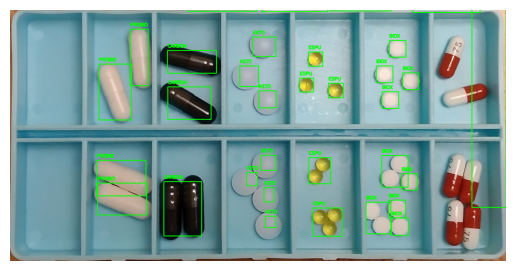

In [19]:
def draw_bounding_boxes_and_labels(image, masks):
    labeled_image = image.copy()
    for pill_type, mask in masks.items():
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(labeled_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(labeled_image, pill_type.name, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    return labeled_image

# Draw bounding boxes and labels
labeled_image = draw_bounding_boxes_and_labels(roi_from_image, masks)


plt.imshow(cv2.cvtColor(labeled_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()